# [실습4] 이미지 분류 모델 성능 개선 및 예측

## 학습 목표

1. 논문에서 제시된 간단한 모델을 구현해봅니다.

2. 이미지 분류 모델의 학습 경과를 모니터링 하는 법을 배웁니다.

3. 분류 모델의 성능을 평가하고 취약점을 파악합니다.

# VGG16 모델을 활용한 웨이퍼 이미지 분류

저번 시간에 만든 Baseline 모델에 이어 이번 시간에는 간단하게 VGG16 모델을 이용하여 데이터를 분류해보도록 하겠습니다.

VGG 모델은 옥스퍼드 대학의 Visual Geometry Group (VGG)에서 개발되었으며, 2014년 ImageNet ILSVRC 대회에서 두 번째로 높은 성능을 보였습니다. 

해당 모델에서는 3x3 크기의 작은 컨볼루션 필터만을 사용합니다. 

이 작은 필터를 여러 번 연속으로 적용하는 것은 큰 필터를 한 번 사용하는 것과 동일한 수용 영역(receptive field)을 가지게 되지만, 더 적은 파라미터와 더 깊은 구조를 가질 수 있게 합니다.

모델의 자세한 구조는 데이터 전처리가 끝나고 난 뒤 모델 클래스 선언 시 설명드리도록 하겠습니다.

## 1. 라이브러리 불러오기

실습에 필요한 라이브러리를 불러오겠습니다.

In [45]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. 데이터 불러오기 및 분할

저번 시간에는 200개의 웨이퍼 이미지를 이용하여 총 1000장의 데이터를 학습시켰습니다. 

그러나 1000장의 이미지는 데이터의 특성을 파악하기에 많이 모자랍니다.  

이번 시간에는 데이터의 크기를 5배로 증가시켜 학습에 사용해보겠습니다.

현재 디렉토리에는 training_csv가 1번부터 4번까지, test_csv와 함께 존재합니다.

In [47]:
os.listdir('./')

['.bash_logout',
 '.bashrc',
 '.ipython',
 '.local',
 '.profile',
 'training_1.csv',
 'training_2.csv',
 'training_3.csv',
 'training_4.csv',
 '[실습4]이미지 분류 모델 성능 개선 및 예측.ipynb',
 'test.csv',
 '.project_file_okay',
 '.bash_history',
 '.ssh',
 '.ipynb_checkpoints',
 '.config',
 '.cache',
 '.nv',
 'train_images.pkl',
 'train_labels.pkl',
 'test_images.pkl',
 'test_labels.pkl']

이 모든 학습 데이터를 불러와 train_csv에, 테스트 데이터는 test_csv에 담도록 하겠습니다. 

In [48]:
# 1번부터 4번까지의 CSV 파일을 순회하며 데이터프레임으로 읽어 리스트에 추가
dfs = []

for i in tqdm(range(1, 5)):
    file_name = f"./training_{i}.csv"
    df = pd.read_csv(file_name,
                    sep=";",  # 데이터 구분자로 세미콜론(;)을 지정
                    decimal=",",  # 소수점으로 쉼표(,)를 사용한 경우 변환
                    usecols=["wafer", "x", "y", "ring", "spot", "trend", "twospots", "crescent"],  # 불러올 컬럼을 지정
                    dtype={  # 각 컬럼의 데이터 타입을 지정
                        "wafer":np.int16,  
                        "x":np.int16,  
                        "y":np.int16,  
                        "ring":np.float64,
                        "spot":np.float64,
                        "trend":np.float64,
                        "twospots":np.float64,
                        "crescent":np.float64}
                        )
    dfs.append(df)

# 모든 데이터프레임을 연결하여 하나의 데이터프레임으로 만듦
train_csv = pd.concat(dfs, ignore_index=True)
train_csv.head()

100%|██████████| 4/4 [00:18<00:00,  4.70s/it]


,wafer,x,y,ring,spot,trend,twospots,crescent
0,1,1,67,0.033203,0.000065,0.312295,0.039043,0.007720
1,1,1,68,0.032817,-0.000005,0.288025,0.040563,0.002636
2,1,1,69,0.033321,0.000025,0.261521,0.041602,-0.000592
3,1,1,70,0.032707,-0.000014,0.290741,0.040822,0.008510
4,1,1,71,0.032220,-0.000049,0.256578,0.042526,0.009654


데이터가 잘 불러와졌는지, 형태를 확인해보도록 합니다.

In [49]:
train_csv.shape

(14007200, 8)

테스트 파일도 불러와보겠습니다.

In [50]:
# 데이터 파일의 경로를 지정
test_path = './test.csv'

# pandas의 read_csv 함수를 사용하여 CSV 파일을 DataFrame 형태로 불러오기
test_csv = pd.read_csv(test_path,
                sep=";",  # 데이터 구분자로 세미콜론(;)을 지정
                decimal=",",  # 소수점으로 쉼표(,)를 사용한 경우 변환
                usecols=["wafer", "x", "y", "ring", "spot", "trend", "twospots", "crescent"],  # 불러올 컬럼을 지정
                dtype={  # 각 컬럼의 데이터 타입을 지정
                    "wafer":np.int16,  
                    "x":np.int16,  
                    "y":np.int16,  
                    "ring":np.float64,
                    "spot":np.float64,
                    "trend":np.float64,
                    "twospots":np.float64,
                    "crescent":np.float64}
                    )

test_csv.head()

,wafer,x,y,ring,spot,trend,twospots,crescent
0,801,1,67,0.081565,0.000213,0.507566,0.020513,-0.000526
1,801,1,68,0.080407,0.000029,0.528584,0.021047,-0.010879
2,801,1,69,0.083291,0.000043,0.498000,0.021185,0.005890
3,801,1,70,0.081118,-0.000052,0.532268,0.022842,-0.001203
4,801,1,71,0.080389,0.000300,0.544996,0.022436,-0.008338


In [51]:
test_csv.shape

(3501800, 8)

학습 데이터가 전체 데이터에서 차지하는 비중을 확인해보도록 하겠습니다.

In [52]:
print(f"Ratio of Train dataset: {len(train_csv) / (len(train_csv) + len(test_csv))}")

Ratio of Train dataset: 0.8


### 2.1 데이터 변환

데이터프레임에서 wafer 별 정보를 추출하여 이미지와 레이블을 생성하도록 하겠습니다.

전처리 과정 실습때 사용했던 함수를 다시 불러와보겠습니다.

In [53]:
defect_features = df.columns[3:].tolist()

In [54]:
def create_images_from_dataframe(csv, wafer_num):
    wafer_data = csv[csv['wafer'] == wafer_num]
    
    images = []
    labels = []
    
    for idx, defect in enumerate(defect_features):
        defect_values = wafer_data.pivot(index='x', columns='y', values=defect).fillna(0).values
        image = np.copy(defect_values)
        images.append(image)
        labels.append(idx)

    return images, labels

### [TODO] 위 함수를 세 데이터셋에 적용하여, 각각의 이미지와 레이블을 `train_images`, `train_labels`, `test_images`, `test_labels` 리스트에 담아주세요.

이번에는 처리할 데이터의 양이 많기 때문에 시간이 다소 걸립니다. 잠시만 기다려주세요.

In [55]:
# 모든 이미지와 레이블을 저장할 리스트 초기화
train_images = []
train_labels = []

unique_wafers = train_csv["wafer"].unique()

# tqdm을 사용하여 진행 상황 표시와 함께 데이터프레임 내의 모든 wafer에 대해 반복
for wafer_num in tqdm(unique_wafers):
    # 각 wafer에 대해 이미지와 레이블 데이터 생성
    images, labels = create_images_from_dataframe(train_csv, wafer_num)
    # 생성된 이미지와 레이블 데이터를 전체 리스트에 추가
    train_images.extend(images)
    train_labels.extend(labels)

train_df = pd.DataFrame({"image": train_images, "label": train_labels})

100%|██████████| 800/800 [00:15<00:00, 50.31it/s]


In [56]:
print(train_df)

                                                  image  label
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      2
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      3
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      4
...                                                 ...    ...
3995  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
3996  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
3997  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      2
3998  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      3
3999  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      4

[4000 rows x 2 columns]


In [57]:
# 모든 이미지와 레이블을 저장할 리스트 초기화
test_images = []
test_labels = []

unique_wafers = test_csv["wafer"].unique()

for wafer_num in tqdm(unique_wafers):
    # 각 wafer에 대해 이미지와 레이블 데이터 생성
    images, labels = create_images_from_dataframe(test_csv, wafer_num)
    # 생성된 이미지와 레이블 데이터를 전체 리스트에 추가
    test_images.extend(images)
    test_labels.extend(labels)

# 이미지와 레이블 데이터를 데이터프레임으로 변환
test_df = pd.DataFrame({"image": test_images, "label": test_labels})

100%|██████████| 200/200 [00:03<00:00, 59.65it/s]


> 예시 코드
```
# 모든 이미지와 레이블을 저장할 리스트 초기화
train_images = []
train_labels = []

# tqdm을 사용하여 진행 상황 표시와 함께 데이터프레임 내의 모든 wafer에 대해 반복
for wafer_num in tqdm(train_csv['wafer'].unique()):
    # 각 wafer에 대해 이미지와 레이블 데이터 생성
    images, labels = create_images_from_dataframe(train_csv, wafer_num)
    # 생성된 이미지와 레이블 데이터를 전체 리스트에 추가
    train_images.extend(images)
    train_labels.extend(labels)

# 이미지와 레이블 데이터를 데이터프레임으로 변환
train_df = pd.DataFrame({'image': train_images, 'label': train_labels})
```
---
```
# 모든 이미지와 레이블을 저장할 리스트 초기화
test_images = []
test_labels = []

# tqdm을 사용하여 진행 상황 표시와 함께 데이터프레임 내의 모든 wafer에 대해 반복
for wafer_num in tqdm(test_csv['wafer'].unique()):
    # 각 wafer에 대해 이미지와 레이블 데이터 생성
    images, labels = create_images_from_dataframe(test_csv, wafer_num)
    # 생성된 이미지와 레이블 데이터를 전체 리스트에 추가
    train_images.extend(images)
    train_labels.extend(labels)

# 이미지와 레이블 데이터를 데이터프레임으로 변환
test_df = pd.DataFrame({'image': test_images, 'label': test_labels})
```

In [58]:
print(train_df.shape, test_df.shape)

(4000, 2) (1000, 2)


데이터 변환에 시간이 오래걸렸기에, 번거로움을 덜고자 모든 이미지와 레이블을 pkl 파일로 저장하도록 하겠습니다.

In [59]:
import pickle

# pickle을 사용하여 labels와 images 저장
train_images_save_path = "train_images.pkl"
train_labels_save_path = "train_labels.pkl"
test_images_save_path = "test_images.pkl"
test_labels_save_path = "test_labels.pkl"

# 학습 이미지 리스트를 'images.pkl' 파일로 저장
with open(train_images_save_path, "wb") as f:
    pickle.dump(train_images, f)

# 학습 레이블 리스트를 'labels.pkl' 파일로 저장
with open(train_labels_save_path, "wb") as f:
    pickle.dump(train_labels, f)

# 학습 이미지 리스트를 'images.pkl' 파일로 저장
with open(test_images_save_path, "wb") as f:
    pickle.dump(test_images, f)

# 학습 레이블 리스트를 'labels.pkl' 파일로 저장
with open(test_labels_save_path, "wb") as f:
    pickle.dump(test_labels, f)

# 이미지와 레이블 데이터를 데이터프레임으로 변환
train_df = pd.DataFrame({"image": train_images, "label": train_labels})

데이터를 불러올 때는 아래 코드를 주석해제하여 사용해주세요

In [60]:
# 'images.pkl'와 'labels.pkl' 파일에서 데이터를 로드하기 위해 pickle 사용
with open("train_images.pkl", "rb") as f:
    loaded_train_images = pickle.load(f)
print(len(loaded_train_images))

with open("train_labels.pkl", "rb") as f:
    loaded_train_labels = pickle.load(f)
print(len(loaded_train_labels))

with open("test_images.pkl", "rb") as f:
    loaded_test_images = pickle.load(f)
print(len(loaded_test_images))

with open("test_labels.pkl", "rb") as f:
    loaded_test_labels = pickle.load(f)
print(len(loaded_test_labels))

# 로드된 이미지와 레이블을 데이터프레임으로 변환
train_df = pd.DataFrame({"image": loaded_train_images, "label": loaded_train_labels})
test_df = pd.DataFrame({"image": loaded_test_images, "label": loaded_test_labels})

4000
4000
1000
1000


In [61]:
train_df.head()

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4


In [62]:
test_df.head()

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4


### 2.2 이미지 시각화

생성된 이미지를 시각화해보겠습니다. 

아래 코드의 `labels` 변수 값을 바꾸어가며 이미지(`train_images`, `test_images`)와 레이블 리스트를 시각화 시켰을 때, 특정 레이블 별로 이미지가 잘 생성되었는지 확인해봅시다.

twospots


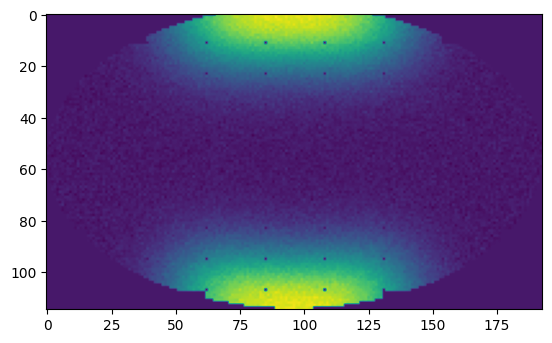

twospots


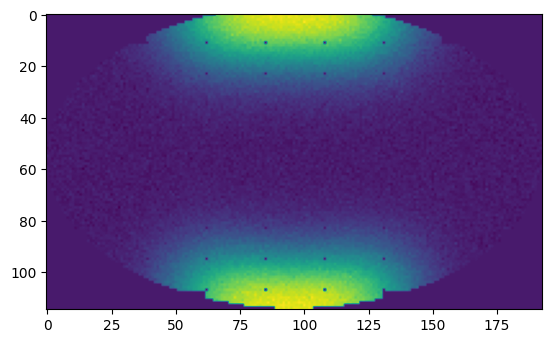

twospots


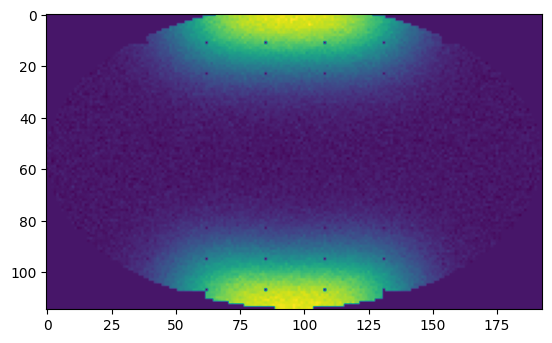

twospots


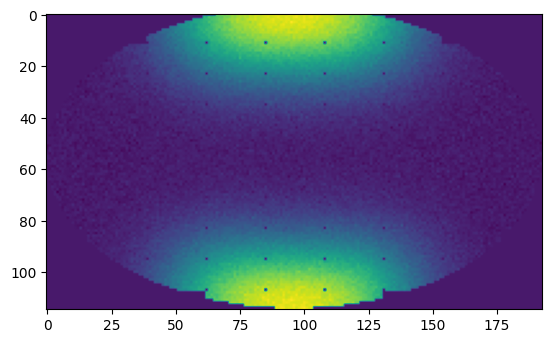

In [63]:
# labels 값을 3으로 설정
labels = 3

# 처음 20개의 이미지 중 레이블이 3인 이미지만 시각화
for i in range(20):
    # 레이블이 3인 경우만 처리
    if train_labels[i] == labels:
        # 해당 레이블에 매치되는 결함 유형 출력
        print(defect_features[labels])
        _ = test_images[i]
        # 해당 이미지 시각화
        plt.imshow(_)
        plt.show()

### 2.3 데이터셋 분할

학습 데이터 중 일부 데이터를 검증(Validation) 데이터로 할당하겠습니다.

학습 데이터와 검증 데이터, 테스트 데이터의 차이는 아래와 같습니다.

- 학습 세트(Training Set):

    - 현실에 존재하는 데이터의 일부

    - 모델을 최적화하기 위한 데이터

    - 모델은 이 데이터를 기반으로 학습하며, 가중치와 편향을 조정하여 예측 오류를 최소화

- 테스트 세트(Test Set):

    - 학습에 포함되지 않은, 현실에 존재하는 데이터로 가정

    - 모델의 최종 성능(일반화 능력)을 평가하는 데 사용

    - 테스트 세트는 모델 학습 및 검증 과정에서 전혀 사용되지 않아야 함

    - 모델이 실제로 새로운, 이전에 본 적 없는 데이터에 얼마나 잘 작동하는지 평가

- 검증 세트(Validation Set):

    - 이 데이터 세트는 학습 중에 모델의 성능을 평가

    - 검증 세트는 학습 도중에 진행되는 테스트 과정이지만, 모델의 가중치 업데이트에 기여를 하지는 않음

    - 이를 테스트 과정 이전에 미리 과적합을 방지하고, 모델의 일반화 성능을 최적화할 수 있음

우리는 학습 데이터의 15%를 검증 데이터로 활용해보도록 하겠습니다.  

다만 데이터를 분할하기 전에 한 번 섞어서 추출해보도록 하겠습니다.

`Scikit-learn`의 `train-test_split`은 데이터셋 분할을 간편하게 수행할 수 있도록 편의를 제공합니다.

In [64]:
# 예시
_data = {
    'Feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Feature2': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'Label': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
}
_df = pd.DataFrame(_data)

# 데이터프레임을 학습 데이터와 테스트 데이터로 분할
_train, _test = train_test_split(_df, test_size=0.2, random_state=42)

print("Training Data:")
print(_train)
print("\nTest Data:")
print(_test)

Training Data:
   Feature1  Feature2  Label
5         6        60      1
0         1        10      0
7         8        80      1
2         3        30      0
9        10       100      1
4         5        50      0
3         4        40      1
6         7        70      0

Test Data:
   Feature1  Feature2  Label
8         9        90      0
1         2        20      1


여기서 `test_size=0.2`는 전체 데이터의 20%를 검증 데이터로 사용하겠다는 의미입니다.

`random_state=42`는 재현 가능한 결과를 얻기 위해 사용되는 랜덤 시드 값입니다. 같은 시드 값을 사용하면 동일한 분할 결과를 얻을 수 있습니다.

### [TODO] 위 예시와 같이, train_df를 train_data와 val_data로 분할해봅시다.

대신, 레이블의 비율을 유지하기 위해 `straify`인자를 넣어주세요. 

해당인자에는 전체 데이터의 레이블 값이 들어가면 됩니다.

In [65]:
# train_test_split을 사용하여 데이터를 학습 데이터와 검증 데이터로 분할합니다.
train_data, val_data = train_test_split(train_df, 
                                        test_size=0.15, 
                                        random_state=42, 
                                        stratify=train_df['label']) # 해당 레이블이 골고루 섞이도록 설정

> 예시코드

```
# train_test_split을 사용하여 데이터를 학습 데이터와 검증 데이터로 분할합니다.
train_data, val_data = train_test_split(train_df, 
                                        test_size=0.15, 
                                        random_state=42, 
                                        stratify=train_df[label])
```

생성된 train_data val_data 형태를 확인해보겠습니다.

In [66]:
print(train_data.shape, val_data.shape)

(3400, 2) (600, 2)


### 2.4 데이터 증강과 데이터셋 생성

모델 입력을 위해 데이터셋을 생성하도록 하겠습니다.

데이터셋 클래스는 이전 실습과 같은 구조로 만들겠습니다.

그에 앞서 데이터 증강 작업을 데이터셋 인스턴스 생성과 함께 수행해보겠습니다.  

`transforms`에 몇 가지 레이만 추가하면 손쉽게 데이터 증강을 수행할 수 있습니다.

그러나 데이터 증강은 학습 데이터에만 적용되어야 하므로 두 가지 `transform` 객체를 생성하겠습니다.

우선은 모든 데이터에 적용되는 `transform`입니다.

In [67]:
# 이미지 데이터의 Min-Max 정규화 함수
def minmax_scaling(img):
    min_val = torch.min(img)
    max_val = torch.max(img)
    if max_val - min_val < 1e-9:  # 작은 값 추가하여 0 방지
        return img
    return (img - min_val) / (max_val - min_val)

# 이미지 변형(리사이징 및 정규화) 파이프라인 정의
base_transform = transforms.Compose([
    transforms.Lambda(minmax_scaling),
    transforms.ToPILImage(),
    transforms.Resize((96, 96)),  # 원하는 크기로 변경
    transforms.ToTensor(),
])

이어서 학습 데이터만 적용되는 transforms 객체를 만들겠습니다.

파이프라인에는 위에서 선언한 `base_transform`에 이어 아래 세 가지 레이어를 추가해주도록 하겠습니다.

- `transforms.RandomHorizontalFlip()`: 이미지를 50%의 확률로 수평으로 뒤집습니다.

- `transforms.RandomRotation(10)`: 이미지를 -10도에서 10도 사이의 무작위 각도로 회전시킵니다.

- `transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)`: 이미지의 밝기, 대비, 채도, 색조를 주어진 범위 내에서 무작위로 조정합니다.

이러한 변환들은 딥러닝 모델의 일반화 능력을 향상시키기 위해 학습 데이터에 적용되는 데이터 증강 기법입니다.

### [TODO] 위에서 설명한 요소들을 모두 모아 `train_transform `에 담아주세요.

In [68]:
# 학습용 이미지 증강 기법 추가
# 데이터 증강을 위한 변환을 정의합니다.
train_transform = transforms.Compose([
    base_transform,  # 기본 변환
    transforms.RandomHorizontalFlip(),  # 이미지를 수평으로 무작위로 뒤집습니다.
    transforms.RandomRotation(10),  # 이미지를 최대 10도까지 무작위로 회전시킵니다.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # 이미지의 밝기, 대비, 채도, 색조를 무작위로 조정합니다.
])

> 예시코드
```
# 데이터 증강을 위한 변환을 정의합니다.
train_transform = transforms.Compose([
    base_transform,  # 기본 변환
    transforms.RandomHorizontalFlip(),  # 이미지를 수평으로 무작위로 뒤집습니다.
    transforms.RandomRotation(10),  # 이미지를 최대 10도까지 무작위로 회전시킵니다.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # 이미지의 밝기, 대비, 채도, 색조를 무작위로 조정합니다.
])

```

두 가지 변환을 transform 이라는 딕셔너리에 담고, 키값을 `train`과 `test`로 설정하여, 상황에 맞게 데이터셋 클래스가 불러올 수 있는 형태로 만들어줍시다.

In [69]:
# 파이프라인 딕셔너리
transform = {
    'train': train_transform,
    'test': base_transform
}

이제 데이터셋을 생성해줍니다. 위에서 데이터 증강을 위한 별도의 파이프라인을 마련했기에, 인스턴스 생성 과정에 파이프라인의 키값을 불러올 수 있어야 합니다.

해당 인자를 `mode`로 주겠습니다.

In [70]:
# 웨이퍼 데이터셋 클래스 정의
class WaferDataset(Dataset):
    def __init__(self, dataframe, mode='train',transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.mode = mode    # 데이터셋 유형 전환
    # 데이터셋의 전체 길이 반환
    def __len__(self):
        return len(self.dataframe)

    # 특정 인덱스의 데이터 반환
    def __getitem__(self, idx):
        image = torch.tensor(self.dataframe.iloc[idx, 0]).float()
        label = torch.tensor(self.dataframe.iloc[idx, 1]).long()
        
        # 변형(transform)이 정의된 경우 적용
        if self.transform:
            image = self.transform[self.mode](image)    # 데이터셋 유형에 따른 키값 호출
        
        return image, label

### [TODO] 데이터셋 클래스로 인스턴스를 생성해보세요. 

학습, 검증, 테스트용 데이터셋이 모두 선언되어야 합니다.

`train_data`, `val_data와` `test_df`를 바탕으로 생성해주어야 합니다.

In [71]:
train_dataset = WaferDataset(train_data, mode='train', transform=transform)
val_dataset = WaferDataset(val_data, mode='test', transform=transform)
test_dataset = WaferDataset(test_df, mode='test', transform=transform)

> 예시코드
```
train_dataset = WaferDataset(train_data, mode='train', transform=transform)
val_dataset = WaferDataset(val_data, mode='test', transform=transform)
test_dataset = WaferDataset(test_df, mode='test', transform=transform)
```

데이터셋 인스턴스의 크기를 확인해보겠습니다.

In [72]:
print(train_dataset.__len__(), 
      val_dataset.__len__(),
      test_dataset.__len__())

3400 600 1000


데이터 수량은 제대로 반영되었습니다. 이번에는 내부를 열어, 이미지와 레이블을 시각화해보겠습니다.

In [73]:
def show_wafermap(dataset, idx):
    # 주어진 인덱스에 해당하는 이미지와 레이블을 가져옴
    image, label = dataset[idx]
    
    # 이미지에서 불필요한 차원 제거 및 numpy 배열로 변환
    image = image.squeeze(0).numpy()
    
    # 레이블을 numpy 배열로 변환
    label = label.numpy()
    
    # 이미지 시각화 설정
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='inferno')  # 이미지 표시
    plt.title(f"Class Label: {label}")  # 이미지 위에 레이블로 제목 설정
    plt.axis('off')  # 축 정보 숨기기
    plt.colorbar(label='Defect Intensity')  # 컬러바 표시 및 라벨 설정
    plt.show()  # 이미지 표시

### [TODO] 학습 데이터셋, 검증 데이터셋, 테스트 데이터셋의 데이터를 시각화해주세요.

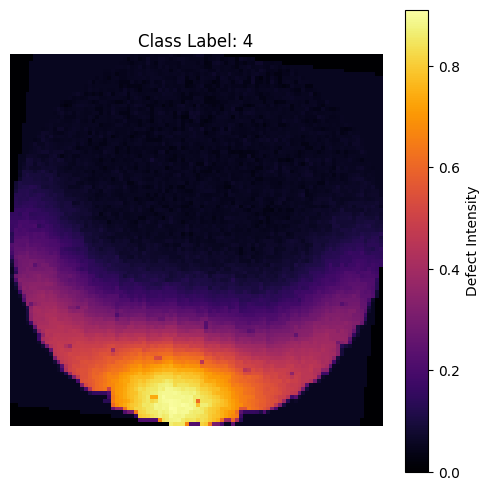

In [74]:
# 학습 데이터셋 이미지를 시각화합니다.
show_wafermap(train_dataset, 21)

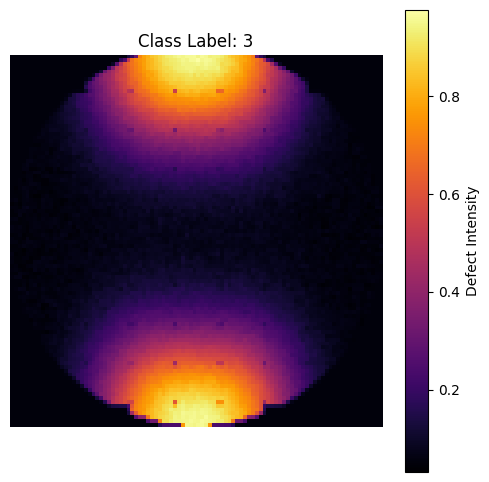

In [75]:
# 검증 데이터셋 이미지를 시각화합니다.
show_wafermap(val_dataset, 112)

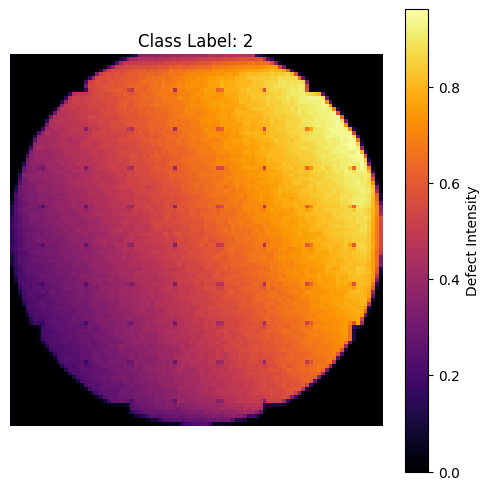

In [76]:
# 테스트 이미지를 시각화합니다.
show_wafermap(test_dataset, 712)

### 2.5 데이터로더 생성

데이터셋을 바탕으로 데이터로더를 생성합니다.

데이터로더에는 배치의 크기를 입력하여 데이터를 해당 크기만큼 분할하는 기능을 제공합니다.

또 `shuffle` 메서드를 통해 학습 시 배치를 무작위로 모델에 입력할지, 순서를 지켜 입력할 지 선택할 수 있는 옵션도 제공합니다.

### [TODO] 각 데이터셋에 대해 데이터 로더를 생성해주세요.

`batch_size`는 32로 설정하고, 학습 데이터에 대해서만 `shuffle`을 적용해주세요.

In [77]:
# 배치 사이즈를 설정합니다.
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

>예시코드
```
# 배치 사이즈를 설정합니다.
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
```

모든 데이터로더가 제대로 생성되었는지 확인해보겠습니다.

In [78]:
print(train_loader.__len__())
print(val_loader.__len__())
print(test_loader.__len__())

107
19
32


## 4. 모델 선언

이번에는 VGG16 모델을 구현해보도록 하겠습니다. 단, 원본 모델의 크기가 상대적으로 크기에, 구조와 가중치의 수는 다소 조정했음을 알려드립니다.

원본 VGG 모델의 구조는 아래와 같습니다.

![출처:commons.wikimedia.org](https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/VGG16.png/800px-VGG16.png?20211021163701)

모델은 총 다섯 층의 컨볼루션 블록과 FCL(Fully Connected Layer)로 구성되어있습니다.

- 각 블록은 여러 개의 컨볼루션 레이어와 Max pooling 레이어로 구성되어 있습니다. 

- 앞의 두 블록은 컨볼루션 레이어가 두 층이며, 나머지 블록들은 전부 세 층으로 구성됩니다.

- 모든 컨볼루션 블록의 첫 번째 레이어는 Feature map의 두께를 2배씩 증가시킵니다.

- 모든 컨볼루션 블록과 FCL은 ReLU 활성화 함수를 거칩니다.

- FCL 중 앞의 두 층은 노드의 수가 1024, 최종 출력층은 클래스의 수와 같습니다.

- 모델은 분류 작업을 해야하므로, 최종 출력층의 활성화 함수는 Softmax를 거칩니다.

### 4.1 모델 선언

### [TODO] 위의 모델 구조도와 아래 지침을 따라 모델 클래스를 완성해주세요. 

다만 모델의 구조를 다소 조정되었기에, 아래 설명을 꼼꼼히 읽어주세요.

1. VGG 클래스 정의:

    nn.Module을 상속받아 VGG 클래스를 정의합니다.

2. 초기화 메서드 (`__init__`):

    `super(VGG16, self).__init__()`을 호출하여 부모 클래스의 초기화 메서드를 실행합니다.

    3개의 블록을 정의합니다. 각 블록은 두 개의 컨볼루션 레이어와 하나의 Max pooling 레이어, 그리고 BatchNorm 층으로 구성됩니다.

    Conv2D 레이어에는 `bias`인자를 `False`로 주도록 합니다.

    `BatchNorm()`레이어의 인자에는 입력받을 Feature의 깊이 값이 들어갑니다.

    마지막으로, 두 층의 FCL를 정의합니다. 앞의 FCL은 노드의 수가 총 256개입니다.
    
    이 레이어는 특징을 클래스 수에 맞게 변환합니다.

3. 순전파 메서드 (forward):

    - 입력 이미지 x를 받아 5개의 블록을 순서대로 통과시킵니다. 
    
    - 각 블록에서는 컨볼루션 레이어를 통과한 후 ReLU 활성화 함수를 적용하고, 마지막으로 Max pooling 레이어를 통과시킵니다.
    
    - 5개의 블록을 통과한 후, 텐서를 펼칩니다`(x.view)`.

    - 펼쳐진 텐서를 완전 연결 레이어를 통과시키고, 마지막으로 softmax 함수를 적용하여 클래스 확률을 반환합니다.

In [91]:
nn.Conv2d?

In [79]:
class VGG(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG, self).__init__()
        
        # Block 1
        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 완전 연결 계층
        self.fc1 = nn.Linear(64 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        
        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.bn3(x)
        x = self.pool3(x)
        
        # 펼치기
        x = x.view(x.size(0), -1)
        
        # 완전 연결 계층
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)

> 예시코드

```
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        
        # Block 1
        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 입력 채널 1, 출력 채널 16
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 최대 풀링
        
        # Block 2
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 4
        self.conv4_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 5
        self.conv5_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 완전 연결 계층
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        
        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        
        # Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        
        # Block 5
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        
        # 펼치기
        x = x.view(x.size(0), -1)
        
        # 완전 연결 계층
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.softmax(x, dim=1)
```

In [80]:
num_classes = len(defect_features)
print(num_classes)

5


### [TODO] 모델 인스턴스를 생성하고, 구조를 출력해주세요.

`print()`메서드를 사용하면 모델의 구조를 확인할 수 있습니다.

In [81]:
# 모델 인스턴스화
model = VGG(num_classes=num_classes)
print(model)

VGG(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): 

> 예시코드
```
# 모델 인스턴스화
model = VGG16(num_classes=num_classes)
print(model)
```

### 4.2 학습 함수 선언

이번에는 학습 함수를 만들어보겠습니다. 저번 시간 활용한 학습 함수와 몇 가지 차이가 있습니다.

1. 검증(Validation) 과정을 거칩니다. 앞서 말씀드렸듯, 검증 과정은 학습 중간에 테스트 과정을 포함시킴으로써 모델의 학습 양상을 평가할 수 있다는 장점이 있습니다.

2. 모델의 검증 손실값(Validation loss)과 검증 정확도(Accuracy)를 출력합니다.

3. 모델 체크포인트를 저장합니다. 저장의 기준은 검증 손실값이 가장 낮을 때이며, 정해진 경로로 저장됩니다.

4. 함수의 반환값은 학습된 모델, 두 가지 손실값이 담긴 리스트로 총 세 개입니다.

### [TODO] 위의 설명을 토대로 학습 함수를 완성해주세요.

헷갈리는 부분은 주석을 통해 채워주세요.

In [82]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device='cuda', save_path='checkpoint.pth'):
    
    model.to(device)  # 모델을 지정된 장치로 이동
    
    train_losses = []  # 학습 손실을 저장하기 위한 리스트
    val_losses = []    # 검증 손실을 저장하기 위한 리스트
    
    best_val_loss = float('inf')  # 최고의 검증 손실을 저장하기 위한 변수
    
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        
        total_train_loss = 0.0
        correct_train = 0
        
        for inputs, labels in train_loader:  # 학습 데이터 로더에서 배치를 가져옴
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터와 레이블을 지정된 장치로 이동
            
            optimizer.zero_grad()  # 최적화 알고리즘의 그래디언트를 초기화
            
            outputs = model(inputs)  # 모델의 예측값을 계산
            loss = criterion(outputs, labels)  # 손실을 계산
            loss.backward()  # 그래디언트를 계산
            optimizer.step()  # 모델의 가중치를 업데이트
            
            total_train_loss += loss.item() * inputs.size(0)  # 총 학습 손실을 업데이트
            
            _, predicted = outputs.max(1)  # 예측된 클래스를 가져옴
            correct_train += (predicted == labels).sum().item()  # 정확한 예측 수를 업데이트
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)  # 평균 학습 손실을 계산
        train_losses.append(avg_train_loss)  # 학습 손실을 리스트에 추가
        train_accuracy = correct_train / len(train_loader.dataset)  # 학습 정확도를 계산
        
        model.eval()  # 모델을 평가 모드로 설정
        total_val_loss = 0.0
        correct_val = 0
        
        with torch.no_grad():  # 그래디언트 계산을 중지
            for inputs, labels in val_loader:  # 검증 데이터 로더에서 배치를 가져옴
                inputs, labels = inputs.to(device), labels.to(device)  # 데이터와 레이블을 지정된 장치로 이동
                
                outputs = model(inputs)  # 모델의 예측값을 계산
                loss = criterion(outputs, labels)  # 손실을 계산
                
                total_val_loss += loss.item() * inputs.size(0)  # 총 검증 손실을 업데이트
                
                _, predicted = outputs.max(1)  # 예측된 클래스를 가져옴
                correct_val += (predicted == labels).sum().item()  # 정확한 예측 수를 업데이트
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)  # 평균 검증 손실을 계산
        val_losses.append(avg_val_loss)  # 검증 손실을 리스트에 추가
        val_accuracy = correct_val / len(val_loader.dataset)  # 검증 정확도를 계산
        
        # 에폭별 학습 및 검증 결과를 출력
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # 최고의 검증 손실보다 현재 검증 손실이 낮으면 모델을 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")
    
    return model, train_losses, val_losses

> 예시코드
```
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device='cuda', save_path='checkpoint.pth'):
    
    model.to(device)  # 모델을 지정된 장치로 이동
    
    train_losses = []  # 학습 손실을 저장하기 위한 리스트
    val_losses = []    # 검증 손실을 저장하기 위한 리스트
    
    best_val_loss = float('inf')  # 최고의 검증 손실을 저장하기 위한 변수
    
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        
        total_train_loss = 0.0
        correct_train = 0
        
        for inputs, labels in train_loader:  # 학습 데이터 로더에서 배치를 가져옴
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터와 레이블을 지정된 장치로 이동
            
            optimizer.zero_grad()  # 최적화 알고리즘의 그래디언트를 초기화
            
            outputs = model(inputs)  # 모델의 예측값을 계산
            loss = criterion(outputs, labels)  # 손실을 계산
            loss.backward()  # 그래디언트를 계산
            optimizer.step()  # 모델의 가중치를 업데이트
            
            total_train_loss += loss.item() * inputs.size(0)  # 총 학습 손실을 업데이트
            
            _, predicted = outputs.max(1)  # 예측된 클래스를 가져옴
            correct_train += (predicted == labels).sum().item()  # 정확한 예측 수를 업데이트
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)  # 평균 학습 손실을 계산
        train_losses.append(avg_train_loss)  # 학습 손실을 리스트에 추가
        train_accuracy = correct_train / len(train_loader.dataset)  # 학습 정확도를 계산
        
        model.eval()  # 모델을 평가 모드로 설정
        total_val_loss = 0.0
        correct_val = 0
        
        with torch.no_grad():  # 그래디언트 계산을 중지
            for inputs, labels in val_loader:  # 검증 데이터 로더에서 배치를 가져옴
                inputs, labels = inputs.to(device), labels.to(device)  # 데이터와 레이블을 지정된 장치로 이동
                
                outputs = model(inputs)  # 모델의 예측값을 계산
                loss = criterion(outputs, labels)  # 손실을 계산
                
                total_val_loss += loss.item() * inputs.size(0)  # 총 검증 손실을 업데이트
                
                _, predicted = outputs.max(1)  # 예측된 클래스를 가져옴
                correct_val += (predicted == labels).sum().item()  # 정확한 예측 수를 업데이트
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)  # 평균 검증 손실을 계산
        val_losses.append(avg_val_loss)  # 검증 손실을 리스트에 추가
        val_accuracy = correct_val / len(val_loader.dataset)  # 검증 정확도를 계산
        
        # 에폭별 학습 및 검증 결과를 출력
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # 최고의 검증 손실보다 현재 검증 손실이 낮으면 모델을 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")
    
    return model, train_losses, val_losses
```

모델 학습에 필요한 손실함수와 옵티마이저를 불러옵니다.

옵티마이저는 Adam, 손실함수는 Cross entropy를 사용하겠습니다.

학습률은 3e-3(0.003)로 설정하며, 이는 옵티마이저의 인자로 입력할 수 있습니다.

학습 횟수는 10회로 설정하겠습니다.

In [83]:
# 옵티마이저와 손실 함수 설정
optimizer = optim.Adam(model.parameters(), lr=1e-6)

criterion = nn.CrossEntropyLoss()

epochs = 25

save_path = './checkpoint.pth'

### 4.3 모델 훈련

훈련을 위한 준비가 끝났습니다. 모델을 훈련시켜보도록 합시다.

### [TODO] 모델 학습 함수를 사용하여 모델을 훈련시켜주세요.

학습함수에 필요한 인자들을 불러와 모델의 학습시킵니다. 

모델의 반환값이 총 세 개이니, `trained_model`, `train_loss`, `val_loss`에 각각 할당해주세요.

In [84]:
print(device)
trained_model, train_loss, val_loss = train_model(model, 
                                                  train_loader, 
                                                  val_loader, 
                                                  optimizer, 
                                                  criterion, 
                                                  num_epochs=epochs, 
                                                  device=device, 
                                                  save_path=save_path)

cuda
Epoch [1/25] - Train Loss: 1.4965, Train Accuracy: 0.6709, Validation Loss: 1.3579, Validation Accuracy: 0.9317
Model saved at ./checkpoint.pth
Epoch [2/25] - Train Loss: 1.2663, Train Accuracy: 0.9653, Validation Loss: 1.1770, Validation Accuracy: 0.9817
Model saved at ./checkpoint.pth
Epoch [3/25] - Train Loss: 1.1296, Train Accuracy: 0.9797, Validation Loss: 1.0696, Validation Accuracy: 0.9900
Model saved at ./checkpoint.pth
Epoch [4/25] - Train Loss: 1.0500, Train Accuracy: 0.9912, Validation Loss: 1.0100, Validation Accuracy: 1.0000
Model saved at ./checkpoint.pth
Epoch [5/25] - Train Loss: 0.9993, Train Accuracy: 0.9944, Validation Loss: 0.9717, Validation Accuracy: 1.0000
Model saved at ./checkpoint.pth
Epoch [6/25] - Train Loss: 0.9680, Train Accuracy: 0.9982, Validation Loss: 0.9484, Validation Accuracy: 1.0000
Model saved at ./checkpoint.pth
Epoch [7/25] - Train Loss: 0.9503, Train Accuracy: 0.9988, Validation Loss: 0.9343, Validation Accuracy: 1.0000
Model saved at ./ch

> 예시코드

```
trained_model, train_loss, val_loss = train_model(model, 
                                                  train_loader, 
                                                  val_loader, 
                                                  optimizer, 
                                                  criterion, 
                                                  num_epochs=epochs, 
                                                  device=device, 
                                                  save_path=save_path)
```

### 4.4 모델 평가

모델의 성능이 잘 나왔습니다. 이번엔 완성된 모델을 테스트 데이터로 평가해보겠습니다.

우선 평가함수를 선언하겠습니다.

In [85]:
def test_model(model, test_loader, criterion, device='cuda'):
        
    # 모델을 평가 모드로 설정.
    model.eval()
    
    # 모델을 지정된 장치로 이동
    model.to(device)
    
    # 전체 손실과 정확도를 계산하기 위한 변수 초기화
    total_loss = 0.0
    correct = 0
    total = 0
    
    # 그래디언트 계산 비활성화 (평가 중에는 필요 없음)
    with torch.no_grad():
        # 테스트 데이터 로더에서 배치 단위로 데이터를 가져와 평가
        for inputs, labels in test_loader:
            # 데이터를 지정된 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 모델을 통해 입력 데이터의 예측값 계산
            outputs = model(inputs)
            # 예측값과 실제 레이블 간의 손실 계산
            loss = criterion(outputs, labels)
            
            # 배치의 손실을 전체 손실에 더함
            total_loss += loss.item() * inputs.size(0)
            
            # 예측값에서 가장 높은 확률을 가진 클래스 선택
            _, predicted = outputs.max(1)
            # 배치의 샘플 수를 전체 샘플 수에 더함
            total += labels.size(0)
            # 올바르게 예측된 샘플 수를 저장
            correct += (predicted == labels).sum().item()
    
    # 평균 테스트 손실과 테스트 정확도 계산
    avg_test_loss = total_loss / total
    test_accuracy = correct / total
    
    # 평균 테스트 손실과 테스트 정확도 출력
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    return avg_test_loss, test_accuracy

위 모델 평가함수를 바탕으로 테스트 데이터에 대한 성능을 평가해보겠습니다.

In [86]:
test_loss, test_accuracy = test_model(trained_model, 
                                      test_loader, 
                                      criterion, device=device)

print(f"Test loss: {test_loss} | Test Accuracy: {test_accuracy}")

Test Loss: 0.9062, Test Accuracy: 1.0000
Test loss: 0.9062292857170104 | Test Accuracy: 1.0


### 4.1 모델 학습 로그 시각화

모델 성능이 검증 결과와 크게 차이나지 않습니다. 이번에는 모델 학습 로그를 그래프로 시각화시켜보겠습니다.

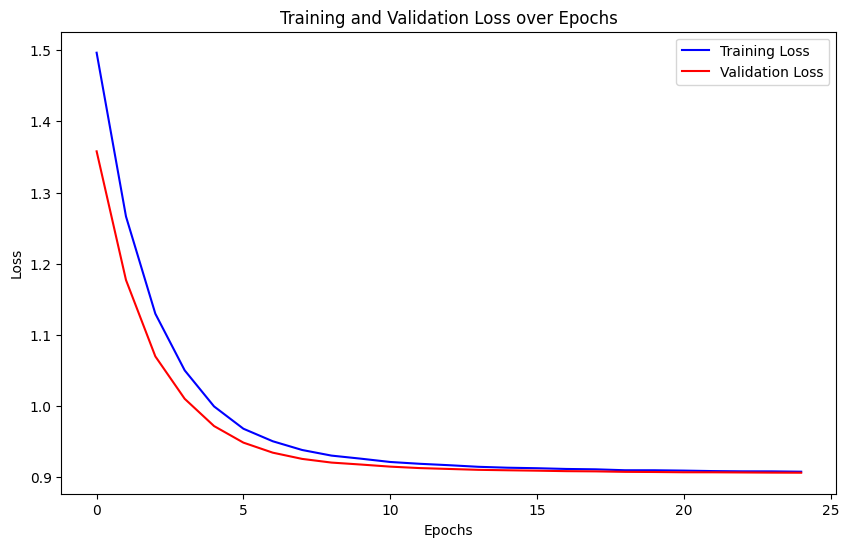

In [87]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')

# 제목 및 레이블 설정
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 4.2 Classification report

classification_report는 분류 작업의 성능을 평가하기 위한 주요 지표를 제공하는 함수입니다. 

이 함수는 `sklearn.metrics` 모듈에 포함되어 있으며, 주로 다음지표를 포함합니다:

1. 정밀도(Precision):

    - 정밀도는 "True로 예측된 것 중에서 실제로 True인 것의 비율"을 나타냅니다.

    - 모델이 True라고 예측한 것 중에서 실제로 True인 것의 비율을 나타냅니다.

2. 재현율(Recall) 또는 민감도(Sensitivity):

    - 재현율은 "실제 True인 것 중에서 True로 예측된 것의 비율"을 나타냅니다.
    
    - 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율을 나타냅니다.

3. F1-Score (F1-Score):

    - F1-Score는 정밀도와 재현율의 조화 평균입니다.
 
    - 정밀도와 재현율이 모두 높을 때 F1-점수도 높아집니다.

4. 지지도(Support):

    - 지지도는 각 클래스에 속하는 실제 인스턴스의 수를 나타냅니다.

    - 예를 들어, 100개의 샘플 중 30개가 클래스 A에 속하면, 클래스 A의 지지도는 30입니다.

[TODO] 모델의 예측 값을 구해주세요.

Classification report를 이용하기 위해선, 모델이 테스트 데이터를 바탕으로 예측한 값들의 레이블을 리스트로 저장해야 합니다.

아래 함수를 완성시켜 모델이 테스트 데이터를 바탕으로 예측값을 계산하고, 이에 짝지어진 레이블을 반환하도록 만들어주세요.

In [88]:
def get_predictions(model, loader, device):    
    all_preds = []  # 예측값을 저장하기 위한 리스트
    all_labels = []  # 실제 레이블을 저장하기 위한 리스트
    
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():  # 그래디언트 계산을 중지
        for inputs, labels in loader:  # 데이터 로더에서 배치를 가져옴
            inputs = inputs.to(device)  # 데이터를 지정된 장치로 이동
            
            # 예측 수행
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스의 인덱스를 가져옴
            
            all_preds.extend(preds.cpu().numpy())  # 예측값을 리스트에 추가
            all_labels.extend(labels.numpy())  # 실제 레이블을 리스트에 추가
    
    return all_preds, all_labels

> 예시코드
```
def get_predictions(model, loader, device):    
    all_preds = []  # 예측값을 저장하기 위한 리스트
    all_labels = []  # 실제 레이블을 저장하기 위한 리스트
    
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():  # 그래디언트 계산을 중지
        for inputs, labels in loader:  # 데이터 로더에서 배치를 가져옴
            inputs = inputs.to(device)  # 데이터를 지정된 장치로 이동
            
            # 예측 수행
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스의 인덱스를 가져옴
            
            all_preds.extend(preds.cpu().numpy())  # 예측값을 리스트에 추가
            all_labels.extend(labels.numpy())  # 실제 레이블을 리스트에 추가
    
    return all_preds, all_labels
```

이제 학습된 모델에서 예측값과 레이블을 얻고, 이를 바탕으로 Classification report를 만들어보겠습니다.

In [89]:
predictions, true_labels  = get_predictions(trained_model, val_loader, device)

In [90]:
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       120

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



어떤가요? 이외에도 다양한 평가지표가 있지만, 분류에서는 대부분 가장 기본이 되는 Classification report의 지표들을 바탕으로 만들어졌습니다. 

이번 모델을 바탕으로 간단한 웨이퍼 데이터에 대한 분류모델을 만들었습니다. 도메인에 적용하실 때에는 더 정교한 작업을 위해 고품질의 데이터와, 이의 특징을 적당한 수의 파라미터로 좋은 결과를 뽑아낼 수 있는 모델이 필요합니다.

이번 실습들을 통해 얻으신 딥러닝 모델 학습법에 대한 관점이 여러분들께 큰 도움이 되길 간절히 바랍니다. 감사합니다.